#MMM Weekly Assessment Pipeline
(With unziped file)

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Loading Data
df = pd.read_csv("/content/Assessment 2 - MMM Weekly.csv")# unziped file

# Ensure correct datetime format
df['week'] = pd.to_datetime(df['week'])

# Sort chronologically
df = df.sort_values('week').reset_index(drop=True)

print("Date range:", df['week'].min(), "to", df['week'].max())
print("Shape:", df.shape)
print(df.head())

Date range: 2023-09-17 00:00:00 to 2025-09-07 00:00:00
Shape: (104, 12)
        week  facebook_spend  google_spend  tiktok_spend  instagram_spend  \
0 2023-09-17         6030.80       3130.14       2993.22          1841.08   
1 2023-09-24         5241.44       2704.00          0.00             0.00   
2 2023-10-01         5893.00          0.00          0.00             0.00   
3 2023-10-08         7167.16          0.00          0.00             0.00   
4 2023-10-15         5360.29          0.00          0.00          3237.15   

   snapchat_spend  social_followers  average_price  promotions  emails_send  \
0         2204.72                 0         101.95           0       102684   
1            0.00                 0         103.86           0        96573   
2            0.00                 0         100.38           0        96797   
3            0.00                 0         103.14           1        99098   
4            0.00                 0         107.76           1       1

Feature Engineering

In [ ]:
# Trend variable
df['timestep'] = np.arange(len(df))

# Weekly seasonality using sine/cosine
df['weekofyear'] = df['week'].dt.isocalendar().week.astype(int)
df['week_sin'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

# Log transform skewed spend/revenue variables (handle zero safely)
for col in ['facebook_spend','google_spend','tiktok_spend','snapchat_spend','revenue']:
    df[f'log_{col}'] = np.log1p(df[col])

Two-Stage Modeling

In [ ]:
# Stage 1: Predict Google spend (mediator) from social spends
X_stage1 = df[['facebook_spend','tiktok_spend','snapchat_spend']]
y_stage1 = df['google_spend']

stage1_model = ElasticNetCV(cv=5, l1_ratio=[.1,.5,.9], random_state=42)
stage1_model.fit(X_stage1, y_stage1)

df['google_hat'] = stage1_model.predict(X_stage1)

# Stage 2: Predict log(revenue) from google_hat + other controls
feature_cols_stage2 = ['google_hat','facebook_spend','tiktok_spend','snapchat_spend',
                       'social_followers','average_price','promotions',
                       'emails_send','sms_send','timestep','week_sin','week_cos']

X_stage2 = df[feature_cols_stage2]
y_stage2 = df['log_revenue']

# Use pipeline with scaling + ElasticNet
stage2_model = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNetCV(cv=5, l1_ratio=[.1,.5,.9], random_state=42))
])

Time-series CV Evaluation

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
r2_scores, rmse_scores = [], []

for train_idx, test_idx in tscv.split(X_stage2):
    X_train, X_test = X_stage2.iloc[train_idx], X_stage2.iloc[test_idx]
    y_train, y_test = y_stage2.iloc[train_idx], y_stage2.iloc[test_idx]

    stage2_model.fit(X_train, y_train)
    preds = stage2_model.predict(X_test)

    r2_scores.append(r2_score(y_test, preds))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

print("\nOut-of-sample performance (log-revenue):")
print("R2:", np.mean(r2_scores), "±", np.std(r2_scores))
print("RMSE:", np.mean(rmse_scores), "±", np.std(rmse_scores))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01971841373525507, tolerance: 0.01601023585259476
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02741770443080327, tolerance: 0.01601023585259476
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038191915473781535, tolerance: 0.01601023585259476
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: C


Out-of-sample performance (log-revenue):
R2: -0.15944636959786823 ± 0.4016147087644749
RMSE: 3.134793646208519 ± 0.577430118507822


Residual Diagnostics

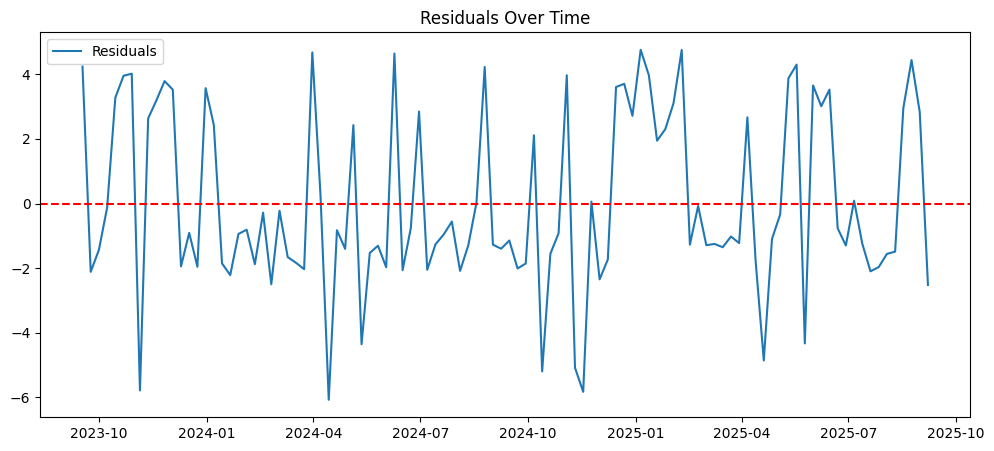

In [ ]:
stage2_model.fit(X_stage2, y_stage2)
df['pred_log_revenue'] = stage2_model.predict(X_stage2)
df['residuals'] = y_stage2 - df['pred_log_revenue']

plt.figure(figsize=(12,5))
plt.plot(df['week'], df['residuals'], label="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time")
plt.legend()
plt.show()

Coefficient Analysis

In [ ]:
coefs = stage2_model.named_steps['enet'].coef_
coef_df = pd.DataFrame({
    'feature': feature_cols_stage2,
    'coefficient': coefs
}).sort_values('coefficient', ascending=False)

print("\nTop drivers of log(revenue):")
print(coef_df)


Top drivers of log(revenue):
             feature  coefficient
8           sms_send     0.615326
11          week_cos     0.200141
3     snapchat_spend     0.137924
0         google_hat     0.000000
9           timestep     0.000000
1     facebook_spend    -0.000000
4   social_followers     0.000000
7        emails_send     0.000000
10          week_sin    -0.000000
6         promotions    -0.189317
2       tiktok_spend    -0.222573
5      average_price    -0.578269


Save Artifacts

In [ ]:
output_dir = "mmm_output_unzipped"
os.makedirs(output_dir, exist_ok=True)

df.to_csv(os.path.join(output_dir, "model_dataframe.csv"), index=False)
coef_df.to_csv(os.path.join(output_dir, "coefficients.csv"), index=False)

print(f"\nArtifacts saved to: {output_dir}")


Artifacts saved to: mmm_output_unzipped


##MMM Weekly Assessment Pipeline
(With ziped file)

In [4]:
# importing libraries
import os, zipfile
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RND = 42
np.random.seed(RND)

# identifying the paths
ZIP_PATH = Path("/content/Assessment 2 - MMM Weekly.csv.zip")
OUT_DIR = Path("./mmm_output")
OUT_DIR.mkdir(exist_ok=True)

# loading CSV from ZIP
def load_csv_from_zip(zip_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        csvs = [n for n in z.namelist() if n.endswith(".csv")]
        if not csvs:
            raise FileNotFoundError("No CSV inside ZIP.")
        with z.open(csvs[0]) as f:
            df = pd.read_csv(f)
    return df

df = load_csv_from_zip(ZIP_PATH)
df['week'] = pd.to_datetime(df['week'])
df = df.sort_values('week').reset_index(drop=True)
print("Date range:", df['week'].min(), "to", df['week'].max())
print("Shape:", df.shape)
print(df.head())

Date range: 2023-09-17 00:00:00 to 2025-09-07 00:00:00
Shape: (104, 12)
        week  facebook_spend  google_spend  tiktok_spend  instagram_spend  \
0 2023-09-17         6030.80       3130.14       2993.22          1841.08   
1 2023-09-24         5241.44       2704.00          0.00             0.00   
2 2023-10-01         5893.00          0.00          0.00             0.00   
3 2023-10-08         7167.16          0.00          0.00             0.00   
4 2023-10-15         5360.29          0.00          0.00          3237.15   

   snapchat_spend  social_followers  average_price  promotions  emails_send  \
0         2204.72                 0         101.95           0       102684   
1            0.00                 0         103.86           0        96573   
2            0.00                 0         100.38           0        96797   
3            0.00                 0         103.14           1        99098   
4            0.00                 0         107.76           1       1

Feature Engineering

In [5]:
df['timestep'] = np.arange(len(df))
df['weekofyear'] = df['week'].dt.isocalendar().week.astype(int)
df['week_sin'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

# Log transforms
for col in ['facebook_spend','google_spend','tiktok_spend','snapchat_spend','revenue']:
    df[f'log_{col}'] = np.log1p(df[col])

# Add lag and rolling features
for c in ['facebook_spend','tiktok_spend','snapchat_spend','google_spend']:
    for lag in [1,2,3,4]:
        df[f"{c}_lag{lag}"] = df[c].shift(lag).fillna(0)
    df[f"{c}_r3"] = df[c].rolling(3, min_periods=1).mean().shift(1).fillna(0)
    df[f"{c}_r13"] = df[c].rolling(13, min_periods=1).mean().shift(1).fillna(0)

Two-stage model:
   - Stage1: Predict Google spend from social channels.
   - Stage2: Predict log(revenue) from predicted Google + other inputs.

In [6]:
# Stage 1: Google as mediator
X1 = df[['facebook_spend','tiktok_spend','snapchat_spend']]
y1 = df['google_spend']
scaler1 = StandardScaler()
X1s = scaler1.fit_transform(X1)
stage1 = ElasticNetCV(l1_ratio=[.1,.5,.9], cv=5, random_state=RND)
stage1.fit(X1s, y1)
df['google_hat'] = stage1.predict(X1s)

# Stage 2: Predict Revenue
features2 = ['google_hat','facebook_spend','tiktok_spend','snapchat_spend',
             'social_followers','average_price','promotions',
             'emails_send','sms_send','timestep','week_sin','week_cos']
X2 = df[features2]
y2 = df['log_revenue']

scaler2 = StandardScaler()
X2s = scaler2.fit_transform(X2)
stage2 = ElasticNetCV(l1_ratio=[.1,.5,.9], cv=5, random_state=RND)

TimeSeries CV

In [11]:
# Evaluate with blocked TimeSeries CV.
tscv = TimeSeriesSplit(n_splits=5)
metrics = []
for tr, te in tscv.split(X2s):
    stage2.fit(X2s[tr], y2.iloc[tr])
    pred = stage2.predict(X2s[te])
    metrics.append({
        "r2": r2_score(y2.iloc[te], pred),
        "rmse": np.sqrt(mean_squared_error(y2.iloc[te], pred)),
        "mae": mean_absolute_error(y2.iloc[te], pred)
    })
metrics_df = pd.DataFrame(metrics)
print(metrics_df, "\nMean:", metrics_df.mean())

         r2      rmse       mae
0 -0.883734  3.606288  3.023036
1 -0.035852  2.224805  1.758531
2  0.141980  3.950796  3.526940
3  0.318312  2.694538  2.153149
4 -0.117326  2.918562  2.542735 
Mean: r2     -0.115324
rmse    3.078998
mae     2.600878
dtype: float64


In [9]:
stage2.fit(X2s, y2)
df['pred_logrev'] = stage2.predict(X2s)
df['pred_revenue'] = np.expm1(df['pred_logrev'])

display(df[['week', 'revenue', 'pred_revenue']].tail())

,week,revenue,pred_revenue
99,2025-08-10,950.45,4211.779013
100,2025-08-17,170470.10,8886.365745
101,2025-08-24,193527.33,2281.081018
102,2025-08-31,65119.20,3843.040035
103,2025-09-07,864.10,10738.092372


Final fit & diagnostics

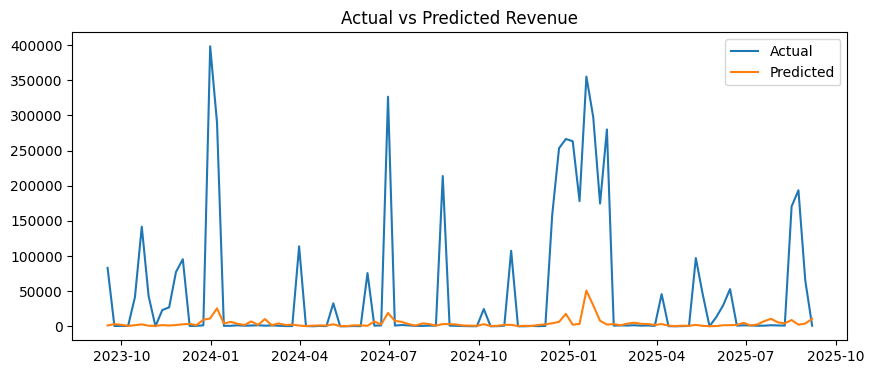

In [ ]:
stage2.fit(X2s, y2)
df['pred_logrev'] = stage2.predict(X2s)
df['pred_revenue'] = np.expm1(df['pred_logrev'])

# Residual plot
plt.figure(figsize=(10,4))
plt.plot(df['week'], df['revenue'], label="Actual")
plt.plot(df['week'], df['pred_revenue'], label="Predicted")
plt.legend(); plt.title("Actual vs Predicted Revenue")
plt.savefig(OUT_DIR / "actual_vs_predicted.png")

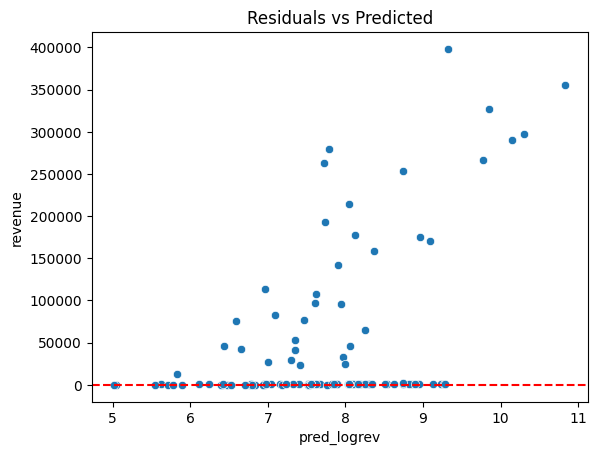

In [ ]:
sns.scatterplot(x=df['pred_logrev'], y=df['revenue'])
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted")
plt.show()

Save artifacts

In [ ]:
df.to_csv(OUT_DIR/"model_dataframe.csv", index=False)
coef_df = pd.DataFrame({
    "feature": features2,
    "coef": stage2.coef_
}).sort_values("coef", key=abs, ascending=False)
coef_df.to_csv(OUT_DIR/"coefficients.csv", index=False)
metrics_df.to_csv(OUT_DIR/"cv_metrics.csv", index=False)